# Day 13 "Transparent Origami"

## Part 1

### Problem

You reach another volcanically active part of the cave. It would be nice if you could do some kind of thermal imaging so you could tell ahead of time which caves are too hot to safely enter.

Fortunately, the submarine seems to be equipped with a thermal camera! When you activate it, you are greeted with:

Congratulations on your purchase! To activate this infrared thermal imaging
camera system, please enter the code found on page 1 of the manual.

Apparently, the Elves have never used this feature. To your surprise, you manage to find the manual; as you go to open it, page 1 falls out. It's a large sheet of transparent paper! The transparent paper is marked with random dots and includes instructions on how to fold it up (your puzzle input). For example:

    6,10
    0,14
    9,10
    0,3
    10,4
    4,11
    6,0
    6,12
    4,1
    0,13
    10,12
    3,4
    3,0
    8,4
    1,10
    2,14
    8,10
    9,0

    fold along y=7
    fold along x=5

The first section is a list of dots on the transparent paper. 0,0 represents the top-left coordinate. The first value, x, increases to the right. The second value, y, increases downward. So, the coordinate 3,0 is to the right of 0,0, and the coordinate 0,7 is below 0,0. The coordinates in this example form the following pattern, where # is a dot on the paper and . is an empty, unmarked position:

    ...#..#..#.
    ....#......
    ...........
    #..........
    ...#....#.#
    ...........
    ...........
    ...........
    ...........
    ...........
    .#....#.##.
    ....#......
    ......#...#
    #..........
    #.#........

Then, there is a list of fold instructions. Each instruction indicates a line on the transparent paper and wants you to fold the paper up (for horizontal y=... lines) or left (for vertical x=... lines). In this example, the first fold instruction is fold along y=7, which designates the line formed by all of the positions where y is 7 (marked here with -):

    ...#..#..#.
    ....#......
    ...........
    #..........
    ...#....#.#
    ...........
    ...........
    -----------
    ...........
    ...........
    .#....#.##.
    ....#......
    ......#...#
    #..........
    #.#........

Because this is a horizontal line, fold the bottom half up. Some of the dots might end up overlapping after the fold is complete, but dots will never appear exactly on a fold line. The result of doing this fold looks like this:

    #.##..#..#.
    #...#......
    ......#...#
    #...#......
    .#.#..#.###
    ...........
    ...........

Now, only 17 dots are visible.

Notice, for example, the two dots in the bottom left corner before the transparent paper is folded; after the fold is complete, those dots appear in the top left corner (at 0,0 and 0,1). Because the paper is transparent, the dot just below them in the result (at 0,3) remains visible, as it can be seen through the transparent paper.

Also notice that some dots can end up overlapping; in this case, the dots merge together and become a single dot.

The second fold instruction is fold along x=5, which indicates this line:

    #.##.|#..#.
    #...#|.....
    .....|#...#
    #...#|.....
    .#.#.|#.###
    .....|.....
    .....|.....

Because this is a vertical line, fold left:

    #####
    #...#
    #...#
    #...#
    #####
    .....
    .....

The instructions made a square!

The transparent paper is pretty big, so for now, focus on just completing the first fold. After the first fold in the example above, 17 dots are visible - dots that end up overlapping after the fold is completed count as a single dot.

How many dots are visible after completing just the first fold instruction on your transparent paper?

### Setup

Data model is a flat array.

In [1]:
from utils import *

_input = initDay('day13')
_sampleFrame1 = getMarkdown('an empty, unmarked position')
_sampleFrame2 = getMarkdown('doing this fold looks like this')
_sampleFrame3 = getMarkdown('vertical line, fold left')
_sample = getMarkdown('For example')

class Board:
    def __init__(self, dots):
        self.cx, self.cy = max(dots[0::2])+1, max(dots[1::2])+1
        self.grid = [0]*self.cx*self.cy
        for x, y in zip(it := iter(dots), it):
            self.grid[self.cx*y+x] = 1

    def __str__(self):
        return '\n'.join(self.render())

    def render(self, cells = '.#'):
        for y in range(self.cy):
            v = ''
            for x in range(self.cx):
                v += cells[1] if self.grid[self.cx*y+x] else cells[0]
            yield v

    def dump(self, cells = '.#'):
        for line in self.render(cells):
            print(line)
        print()

    def image(self):
        # render black on white, which tesseract likes better
        img = Image.frombytes('L', (self.cx, self.cy), bytes(
            (0 if self.grid[self.cx*y+x] else 255) for y in range(self.cy) for x in range(self.cx)))

        # tesseract also needs bigger text and a border
        img = ImageOps.expand(img.resize((self.cx*5, self.cy*5)), 20, 255)

        return img

    def used(self):
        return self.cx*self.cy - self.grid.count(0)

def parse(text):
    parts = text.split('\n\n')
    return (
        Board([int(v) for v in re.findall(r'\d+', parts[0])]),
        [(xy, int(v)) for (xy, v) in re.findall(r'([xy])=(\d+)', parts[1])])

### Solution

This is a straightforward rect copying problem, with just three little wrinkles:

1. The top/left rect may need to be offset, because it's aligned to the other side.
2. The bottom/right rect needs mirroring as it is copied.
3. It's a merge, not a copy, so do an "additive blend"

*Example*

Y-fold where bottom half smaller than top

    ...#..#..#. 0   ...#..#..#. 0     top copied forward
    ....#...... 2   ....#...... 2
    ........... 3   #.#........ 3,7   bottom copied in reverse and offset
    ......#...# 4   #.....#...# 4,6
    ----------- 5
    #.......... 6
    #.#........ 7

Y-fold where top half smaller than bottom

                    #.#........   6   same as above except top is offset
                    #..........   5
    ...#..#..#. 0   ...#..#..## 0,4
    ....#...... 1   ....#...... 1,3
    ----------- 2
    ........... 3
    ......#...# 4
    #.......... 5
    #.#........ 6

The overall algorithm is basic. Copy spans either in two sections (y-fold) or in pairs of spans in a single section (x-fold). The second section/spam needs to be reversed, and there are a pile of little off-by-one errors to stumble over in this problem.

After solving it, I later tried messing around with a more general approach for a single x/y fold handler, but the setup of the offsets got messy, the algorithm hard to read. The special-casing of x and y is plenty simple and small, so we'll ship that.

In [2]:
def fold(b, dir, cut):
    def span(grid, count, dst, src):
        for i in range(c := abs(count)):
            grid[dst + i*count//c] += b.grid[src+i]

    if dir == 'x':
        cx = max(cl := cut, cr := b.cx-cut-1) # total/left/right width
        grid = [0]*cx*b.cy
        for dst, src in [((y+1)*cx, y*b.cx) for y in range(b.cy)]:
            span(grid,  cl, dst-cl, src)
            span(grid, -cr, dst-1,  src+cl+1)
        b.cx, b.grid = cx, grid
    else:
        cy = max(ct := cut, cb := b.cy-cut-1) # total/top/bottom height
        grid = [0]*b.cx*cy
        for y in range(ct):
            span(grid, b.cx, (y+cy-ct)*b.cx, y*b.cx)
        for y in range(cb):
            span(grid, b.cx, (cy-y-1)*b.cx, (y+ct+1)*b.cx)
        b.cy, b.grid = cy, grid

def solve1(text):
    board, folds = parse(text)
    fold(board, folds[0][0], folds[0][1])
    return board.used()

sampleBoard, sampleFolds = parse(_sample)
check(str(sampleBoard), _sampleFrame1)
fold(sampleBoard, sampleFolds[0][0], sampleFolds[0][1])
check(str(sampleBoard), _sampleFrame2)
fold(sampleBoard, sampleFolds[1][0], sampleFolds[1][1])
check(str(sampleBoard), _sampleFrame3)

check(solve1(_sample), 17)
check1(solve1(_input))

Part 1 Result: 775


## Part 2

### Problem

Finish folding the transparent paper according to the instructions. The manual says the code is always eight capital letters.

What code do you use to activate the infrared thermal imaging camera system?

### Solution

Same as Part 1, just don't have it stop at one fold.

Sample


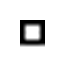

Input


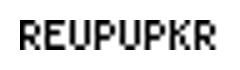

Part 2 Result: REUPUPKR



In [3]:
import pytesseract
from PIL import Image, ImageOps

def solve2(text):
    board, folds = parse(text)
    for fd, fv in folds:
        fold(board, fd, fv)
    return board

sampleSolve2 = solve2(_sample)
check(sampleSolve2.used(), 16)
print("Sample")
display(sampleSolve2.image())

inputSolve2 = solve2(_input).image()
print("Input")
display(inputSolve2)
check2(pytesseract.image_to_string(inputSolve2))